In [10]:
!pip install -q keras-tqdm

import math
import os
import pickle
import random
import sys
import time
from contextlib import suppress
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [3]:
crime_test = pd.read_csv("test.csv", sep=',',error_bad_lines=False)
crime_train = pd.read_csv("train.csv", sep=',',error_bad_lines=False)

In [4]:
def transformX(dataset):
  dataset.loc[:, 'DayOfWeek'] = np.array([time.strptime(dow, '%A').tm_wday for dow in dataset.loc[:, 'DayOfWeek']], dtype=np.float)
  dataset.loc[:, 'Address'] = np.array([1 if 'block' in row else 0 for row in dataset.loc[:, 'Address']], dtype=np.float)
  # Districts
  districts = sorted(dataset.PdDistrict.unique())
  for d in districts:
    dataset.loc[:, d] = np.array([1 if d == x else 0 for x in dataset.loc[:, 'PdDistrict']], dtype=np.float)
  # Date
  datefmt = '%Y-%m-%d %H:%M:%S'
  def transform_time(tm):
    if tm.hour >= 0 and tm.hour <= 6:
      return 0
    elif tm.hour >= 6 and tm.hour <= 12:
      return 1
    elif tm.hour >= 12 and tm.hour <= 18:
      return 2
    return 3
  dataset.loc[:, 'Year'] = np.array([datetime.strptime(row, datefmt).year for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Month'] = np.array([datetime.strptime(row, datefmt).month for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Day'] = np.array([datetime.strptime(row, datefmt).day for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Hour'] = np.array([datetime.strptime(row, datefmt).time().hour for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Minute'] = np.array([datetime.strptime(row, datefmt).time().minute for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Period'] = np.array([transform_time(datetime.strptime(row, datefmt).time()) for row in dataset.loc[:, 'Dates']], dtype=np.float)
  return dataset.drop(columns=['PdDistrict', 'Dates'])

In [5]:
# raw_train = pd.read_csv(crime_train)
X_train = crime_train[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
Y_train = crime_train['Category']
# del raw_train

X_train = transformX(X_train)
Y_labels = sorted(Y_train.unique())
Y_train = np.array([Y_labels.index(cat) for cat in Y_train], dtype=np.float)

# raw_test = pd.read_csv(crime_test)
X_test = crime_test[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
# del raw_test

X_test = transformX(X_test)

C:\Users\Abhishek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Abhishek\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [6]:
scaler = StandardScaler()
pca = PCA()
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

xy = X_train[['X', 'Y']].to_numpy()
X_train.drop(columns=['X', 'Y'], inplace=True)
scaler.fit(xy)
xy = scaler.transform(xy)
pca.fit(xy)
xy_train = pca.transform(xy)

xy_test = pca.transform(scaler.transform(X_test[['X', 'Y']].to_numpy()))
X_test.drop(columns=['X', 'Y'], inplace=True)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.append(X_train, xy_train, axis=1)
X_test = np.append(X_test, xy_test, axis=1)

train_idx, val_idx = next(ss_split.split(X_train, Y_train))
X_val, Y_val = X_train[val_idx], Y_train[val_idx]
X_train, Y_train = X_train[train_idx], Y_train[train_idx]

#Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=len(Y_labels))
#Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=len(Y_labels))

In [7]:
nb = BernoulliNB()
nb.fit(X_train, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [8]:
preds = nb.predict_proba(X_test)
predictions = pd.DataFrame(preds, columns=Y_labels)
predictions.index.name = 'Id'
predictions.to_csv('bernoullinb_preds.csv')
print(predictions)

           ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
Id                                                           
0       0.003999  0.119299    0.000026  0.001144  0.018686   
1       0.003999  0.119299    0.000026  0.001144  0.018686   
2       0.000920  0.064600    0.000055  0.000195  0.068205   
3       0.001787  0.088318    0.000038  0.000734  0.048888   
4       0.001787  0.088318    0.000038  0.000734  0.048888   
...          ...       ...         ...       ...       ...   
884257  0.001526  0.095856    0.001929  0.000300  0.025313   
884258  0.001600  0.061353    0.003814  0.000079  0.133991   
884259  0.002814  0.075988    0.002391  0.000270  0.087006   
884260  0.007600  0.123833    0.001955  0.000508  0.040121   
884261  0.002013  0.055012    0.003237  0.000091  0.103845   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
Id                                                                       
0                 0.001435                   

In [84]:
print (x_train)

        DayOfWeek  Address  BAYVIEW  CENTRAL  INGLESIDE  MISSION  NORTHERN  \
0             2.0      0.0      0.0      0.0        0.0      0.0       1.0   
1             2.0      0.0      0.0      0.0        0.0      0.0       1.0   
2             2.0      0.0      0.0      0.0        0.0      0.0       1.0   
3             2.0      0.0      0.0      0.0        0.0      0.0       1.0   
4             2.0      0.0      0.0      0.0        0.0      0.0       0.0   
...           ...      ...      ...      ...        ...      ...       ...   
878044        0.0      0.0      0.0      0.0        0.0      0.0       0.0   
878045        0.0      0.0      0.0      0.0        1.0      0.0       0.0   
878046        0.0      0.0      0.0      0.0        0.0      0.0       0.0   
878047        0.0      0.0      0.0      0.0        0.0      0.0       0.0   
878048        0.0      0.0      1.0      0.0        0.0      0.0       0.0   

        PARK  RICHMOND  SOUTHERN  TARAVAL  TENDERLOIN    Year  

In [80]:
print (accuracy_score(Y_val, nb.predict(X_val))*100)
print (log_loss(Y_val, nb.predict_proba(X_val)))

21.88087238767724
0.21803174368165776
0.2188087238767724
2.6289805220282396


In [88]:
n_classes = len(Y_labels)
y_test = tf.keras.utils.to_categorical(Y_val, num_classes=len(Y_labels))
y_pred = nb.predict_proba(X_val)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [89]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [90]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

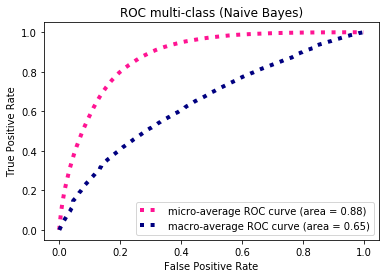

In [92]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

In [166]:
cm = confusion_matrix(Y_val, nb.predict(X_val))
print (Y_val)
print (nb.predict(X_val))

[20. 16. 21. ...  1. 16. 16.]
[16.  7. 16. ... 36. 16. 16.]


In [138]:
print (cm)
class_accuracies = cm.diagonal()/cm.sum(axis=1)
print (class_accuracies)

[[   0    0    0 ...   34    0    0]
 [   0    0    0 ... 1924    0    0]
 [   0    0    0 ...   16    0    0]
 ...
 [   0    0    0 ... 3203    0    0]
 [   0    0    0 ...  644    0    0]
 [   0    0    0 ...  173    0    0]]
[0.         0.         0.         0.         0.         0.
 0.         0.3627015  0.         0.         0.         0.
 0.         0.         0.         0.         0.63747856 0.
 0.         0.         0.04376794 0.32493264 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.29778728 0.         0.        ]


In [129]:
print(classification_report(Y_val, nb.predict(X_val), target_names=Y_labels))

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  


                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.00      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.21      0.36      0.26     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [158]:
labels, counts = np.unique(crime_train['Category'], return_counts=True)
print (labels)
print (counts)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']
[  1513  76876    406    289  36755   4320   2268  53971   4280   1166
    256    491  10609  16679    146   2341 174900   1903   1225  25989
  92304 126182     22   7484   3138  23000   1946   9985   4388    148
   4540    508  31414      6   7326  44725  53781  42214   8555]


In [163]:
sort_lc = zip(counts, labels)
sort_lc = sorted(sort_lc, key=lambda x:x[0], reverse=True)
labels = [y for x,y in sort_lc]
counts = [x for x,y in sort_lc]
print (labels)
print (counts)

['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS', 'BURGLARY', 'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY', 'FRAUD', 'FORGERY/COUNTERFEITING', 'SECONDARY CODES', 'WEAPON LAWS', 'PROSTITUTION', 'TRESPASS', 'STOLEN PROPERTY', 'SEX OFFENSES FORCIBLE', 'DISORDERLY CONDUCT', 'DRUNKENNESS', 'RECOVERED VEHICLE', 'KIDNAPPING', 'DRIVING UNDER THE INFLUENCE', 'RUNAWAY', 'LIQUOR LAWS', 'ARSON', 'LOITERING', 'EMBEZZLEMENT', 'SUICIDE', 'FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY', 'EXTORTION', 'SEX OFFENSES NON FORCIBLE', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT', 'TREA']
[174900, 126182, 92304, 76876, 53971, 53781, 44725, 42214, 36755, 31414, 25989, 23000, 16679, 10609, 9985, 8555, 7484, 7326, 4540, 4388, 4320, 4280, 3138, 2341, 2268, 1946, 1903, 1513, 1225, 1166, 508, 491, 406, 289, 256, 148, 146, 22, 6]


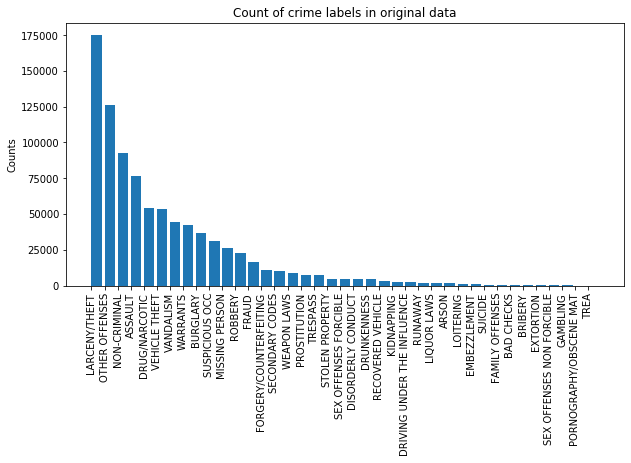

In [164]:
y_pos = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(y_pos, counts, align='edge', width=0.8)
plt.xticks(y_pos, labels, rotation='vertical')
plt.ylabel('Counts')
plt.title('Count of crime labels in original data')
plt.subplots_adjust(bottom=0.15)
plt.show()

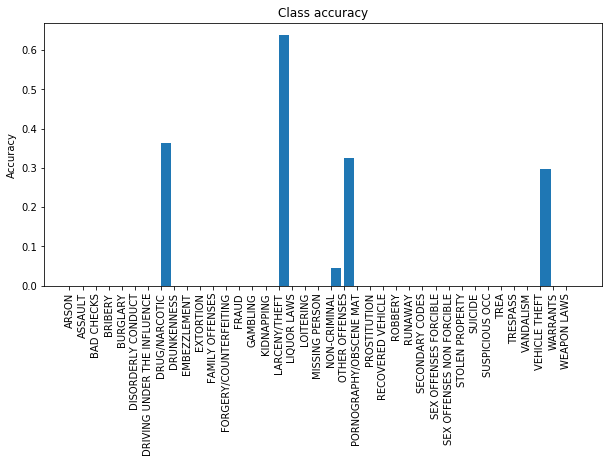

In [137]:
y_pos = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(y_pos, class_accuracies, align='edge', width=0.8)
plt.xticks(y_pos, labels, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Class accuracy')
plt.subplots_adjust(bottom=0.15)
plt.show()

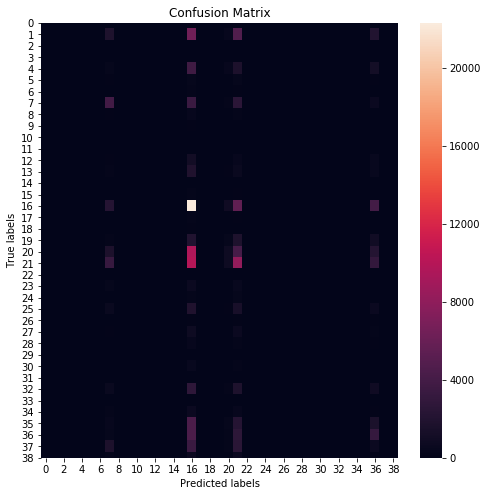

In [143]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

[[ 1.01789431  0.          2.96954082 ... -1.65536577  0.4765178
  -0.53507971]
 [ 1.01789431  0.         -0.3367524  ... -1.65536577 -0.18049175
   0.1838553 ]
 [-0.50338734  0.         -0.3367524  ...  0.30147349  0.03441305
  -0.0594617 ]
 ...
 [-1.5175751   0.         -0.3367524  ... -1.65536577  0.21047047
  -0.17690824]
 [ 1.52498819  0.         -0.3367524  ...  0.30147349  0.27856649
  -0.24683844]
 [ 0.51080043  0.         -0.3367524  ... -1.65536577  0.34701553
  -0.31681134]]


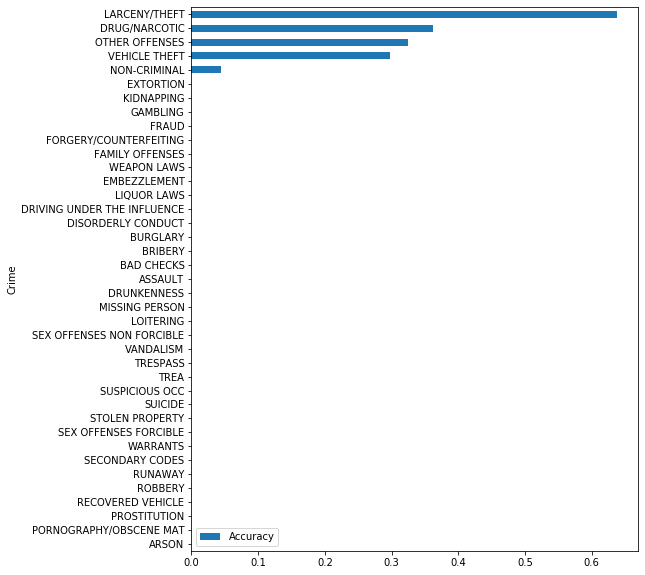

In [11]:
Y_val_pred = nb.predict(X_val)
cm = confusion_matrix(Y_val, Y_val_pred)
class_accuracies = cm.diagonal()/cm.sum(axis=1)
#print (class_accuracies)
#print(classification_report(y_val_true, Y_val_pred, target_names=Y_labels))

class_ac = pd.DataFrame(data=[Y_labels, class_accuracies], index=['Crime', 'Accuracy']).T
class_ac = class_ac.sort_values(by='Accuracy')
class_ac.plot(x='Crime', y='Accuracy', kind='barh', figsize=(8,10))